### 1) Import Libraries and dataset

In [1]:
# Import Libraries

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 

This project uses a set of 50K IMBD Reviews that has been web scraped from IMDB.com to build a NLP machine learning model. The reviews are classified according to both positive and negative sentiments respectively. This dataset will be utilized to build a  classifier model that will be able to accurately predict both positive and negative sentiments.

In [2]:
# Load in dataset

data = pd.read_csv("IMDB_Reviews_Dataset.csv")

### 2) Analysing Data

In [3]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
data.shape

(50000, 2)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


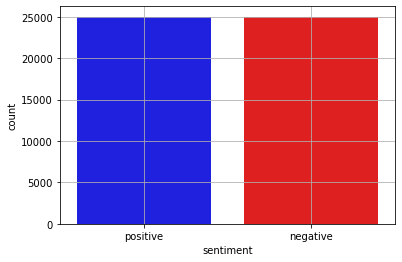

In [6]:
sns.countplot(x= data["sentiment"], palette = ["blue","red"])
plt.grid();

- We can see that our data frame has a equal number of positive and negative sentiments
- This will be beneficial for building our model as we will be able to predict both negative and positive comments with a similar accuracy

### 2) Text pre-processing

#### Before buiding our model we need to prep the data in the reviews column by: 
- Removing punctuations, html tags(from web scraping)
- Convert letters from upper to lower case 
- Remove special charcters

In [7]:
# Creating a function using regex to clean the data

import re
def preprocessor(text):
             text=re.sub('<[^>]*>','',text)
             emojis=re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',text)
             text=re.sub('[\W]+',' ',text.lower()) +\
                ' '.join(emojis).replace('-','')
             return text  

In [8]:
# Testing the preprocessor function

print(preprocessor("They are right, as this is exactly what happened with me.<br /><br />"))

they are right as this is exactly what happened with me 


- The function is working as intended, we were able to strip out the html tags, convert upper case letters to lower and remove punctuations

In [9]:
# Applying the function to our dataframe

data['review']=data['review'].apply(preprocessor)

In [10]:
data.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there s a family where a little boy ...,negative
4,petter mattei s love in the time of money is a...,positive


### Visualizing postive and negative words 

In [11]:
# Using stopwords to ignore non-essential words which does not add further meaning 

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop=stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nxf73621\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Positive words are as follows


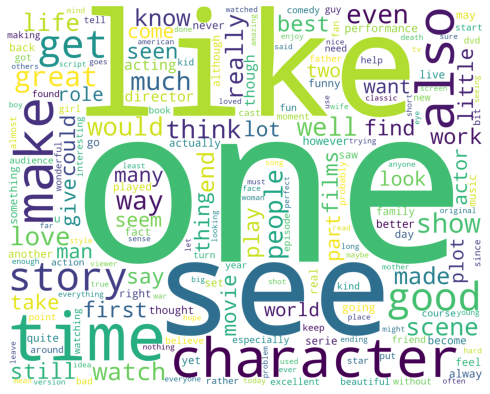

Negative words are as follows


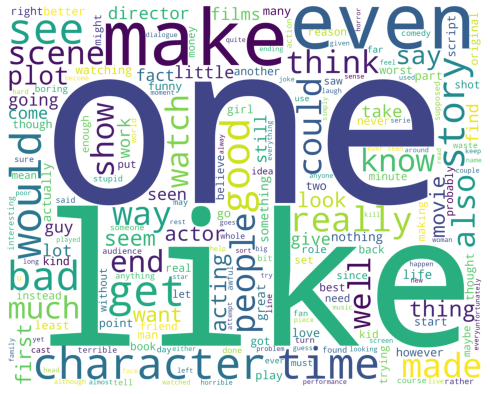

In [12]:
from wordcloud import WordCloud
positivedata = data[ data['sentiment'] == 'positive']
positivedata =positivedata['review']
negdata = data[data['sentiment'] == 'negative']
negdata= negdata['review']

def wordcloud_draw(data, color = 'white'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                              if(word!='movie' and word!='film')
                            ])
    wordcloud = WordCloud(stopwords=stop,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(10, 7))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words are as follows")
wordcloud_draw(positivedata,'white')
print("Negative words are as follows")
wordcloud_draw(negdata)

#### Positive words that are highlighted:
- Great, good, like, love, well

#### Negative words that are highlighted:
- bad, little, terrible, nothing

There are some positive words 'like' and 'good' that were highlighted from the negative sentiments data. Upon further examination, although these words have a positive implication when used individualy they were used in a negative context as highlighted below:
- Sort of like a high school film project
- It was watchable and as good as the first film in the beginning but from the part where the protagonists get super powers in theirs dreams, it started to become childish

### 3) Model Building

Before we select and train our model we will first need to vectorize our dataset. Vectorization converts our data into a linear matrix which helps to improve the efficiency of our code by reducing overall processing time. There are 2 popular vectorization methods which are Bag-of-words and Term Frequency Inverse Document Frequency(TFIDF). We will be using TFIDF as it has several advantages when it come to larger size datasets.

#### TFIDF vectorization

In [13]:
# Using porter stemmer as a tokenizer to reduce words to it's stem

from nltk.stem.porter import PorterStemmer

porter=PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [14]:
# TFIDF vectorizer function

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

tfidf=TfidfVectorizer(strip_accents=None,lowercase=False,preprocessor=None,tokenizer=tokenizer_porter,use_idf=True,norm='l2',smooth_idf=True)

#### Fitting and Transforming Data

In [15]:
# Fitting and transforming the TFIDF vectorizer to the reviews column

y=data.sentiment.values
x=tfidf.fit_transform(data.review)


#### Splitting Data

In [16]:
# Split arrays or matrices into random train and test subsets

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(x,y,random_state=42,test_size=0.33,shuffle=False)

We selected a 67% test and 33% train split combination, ideally the more training data we have the better our model gets

In [17]:
# 33500 train values, 66% train & 33% test split 

print(np.count_nonzero(y_train))
print(np.count_nonzero(y_train=='positive'))
print(np.count_nonzero(y_train=='negative'))

33500
16735
16765


#### Selecting and Training Model

Scikit Learn offers many different types of models for supervised learning. One such model available for classification is the Support vector machines (SVMs) method which are commonly used for for classification, regression and outliers detection.

In [18]:
from sklearn import svm

clf_svm = svm.SVC(kernel='linear')

clf_svm.fit(X_train, y_train)

SVC(kernel='linear')

### 4) Evaluating Model

To evaluate our model we can generate different metrics like precision, recall, F1 score and support 

In [19]:
# Accuracy

print(clf_svm.score(X_test, y_test))

0.8960606060606061


In [20]:
# F1 Scores
from sklearn.metrics import f1_score

f1_score(y_test, clf_svm.predict(X_test), average=None, labels=['positive','negative'])

array([0.89674273, 0.89536941])

In [21]:
# Classification Report

from sklearn.metrics import classification_report
y_pred = clf_svm.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.90      0.89      0.90      8235
    positive       0.89      0.90      0.90      8265

    accuracy                           0.90     16500
   macro avg       0.90      0.90      0.90     16500
weighted avg       0.90      0.90      0.90     16500



This SVM model has an accuracy score of 90% with a good balance of precision, recall and F1 scores for both negative and positive sentiment classification

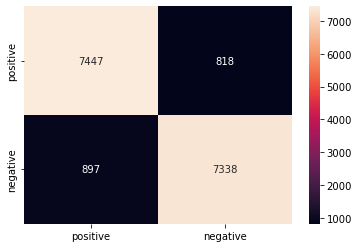

In [22]:
# Confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib as plt

labels = ['positive','negative']

cm = confusion_matrix(y_test, y_pred, labels=labels)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

sn.heatmap(df_cm, annot=True, fmt='d');

#### From the confusion metrics, we can see that:
- 7447 were true positives
- 818 were false positives
- 7338 were true negatives
- 897 were false negatives

#### Making Predictions with the SVM Model

In [23]:
test_set = ['very exciting', "bad movie don't watch", 'horrible waste of time']
new_test = tfidf.transform(test_set)

clf_svm.predict(new_test)

array(['positive', 'negative', 'negative'], dtype=object)

In [24]:
positive_comment = ['this film is very nice and good i like it']
negative_comment = ['no not good look at that scene very bad']

pos_comment = tfidf.transform(positive_comment)
neg_comment = tfidf.transform(negative_comment)

In [25]:
# Postive comment prediction

clf_svm.predict(pos_comment)

array(['positive'], dtype=object)

In [26]:
# Negative comment prediction

clf_svm.predict(neg_comment)

array(['negative'], dtype=object)

The SVM model was able to accurately predict both postive and negative sentiments